# Legal Document Analysis and Classification Using NLP and Deep Learning

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import re

# Load the dataset
file_path = 'justice.csv'
data = pd.read_csv(file_path)

C:\Users\citris\anaconda4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\citris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\citris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\citris\anaconda4\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Display the first few rows of the dataset
data.head()

Unnamed: 0     ID                     name  \
0           0  50606              Roe v. Wade   
1           1  50613      Stanley v. Illinois   
2           2  50623  Giglio v. United States   
3           3  50632             Reed v. Reed   
4           4  50643     Miller v. California   

                                      href   docket  term  \
0    https://api.oyez.org/cases/1971/70-18    70-18  1971   
1  https://api.oyez.org/cases/1971/70-5014  70-5014  1971   
2    https://api.oyez.org/cases/1971/70-29    70-29  1971   
3     https://api.oyez.org/cases/1971/70-4     70-4  1971   
4    https://api.oyez.org/cases/1971/70-73    70-73  1971   

           first_party   second_party  \
0             Jane Roe     Henry Wade   
1  Peter Stanley, Sr.        Illinois   
2         John Giglio   United States   
3           Sally Reed     Cecil Reed   
4        Marvin Miller     California   

                                               facts  facts_len  \
0  <p>In 1970, Jane Roe (a fictional name used in...        501   
1  <p>Joan Stanley had three children with Peter ...        757   
2  <p>John Giglio was convicted of passing forged...        495   
3  <p>The Idaho Probate Code specified that "male...        378   
4  <p>Miller, after conducting a mass mailing cam...        305   

   majority_vote  minority_vote first_party_winner     decision_type  \
0              7              2               True  majority opinion   
1              5              2               True  majority opinion   
2              7              0               True  majority opinion   
3              7              0               True  majority opinion   
4              5              4               True  majority opinion   

         disposition       issue_area  
0           reversed              NaN  
1  reversed/remanded     Civil Rights  
2  reversed/remanded      Due Process  
3  reversed/remanded     Civil Rights  
4   vacated/remanded  First Amendment

In [3]:
# Summary statistics
data.describe()

Unnamed: 0            ID    facts_len  majority_vote  minority_vote
count  3303.000000   3303.000000  3303.000000    3303.000000    3303.000000
mean   1651.000000  56336.505298  1112.496821       7.009688       1.727823
std     953.638296   3600.259018   531.514960       1.726244       1.604460
min       0.000000  50606.000000    26.000000       0.000000       0.000000
25%     825.500000  54339.500000   757.000000       5.000000       0.000000
50%    1651.000000  55260.000000  1049.000000       7.000000       2.000000
75%    2476.500000  59437.500000  1381.000000       9.000000       3.000000
max    3302.000000  63335.000000  6201.000000       9.000000       4.000000

In [4]:
# Check for missing values
data.isnull().sum()

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [5]:
# Unique values in each column
for column in data.columns:
    unique_values = data[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in Unnamed: 0: [   0    1    2 ... 3300 3301 3302]
Unique values in ID: [50606 50613 50623 ... 63331 63332 63335]
Unique values in name: ['Roe v. Wade' 'Stanley v. Illinois' 'Giglio v. United States' ...
 'Terry v. United States' 'United States v. Cooley'
 'PennEast Pipeline Co. v. New Jersey']
Unique values in href: ['https://api.oyez.org/cases/1971/70-18'
 'https://api.oyez.org/cases/1971/70-5014'
 'https://api.oyez.org/cases/1971/70-29' ...
 'https://api.oyez.org/cases/2020/19-1414'
 'https://api.oyez.org/cases/2020/142-orig'
 'https://api.oyez.org/cases/2020/19-1039']
Unique values in docket: ['70-18' '70-5014' '70-29' ... '20-5904' '19-1414' '19-1039']
Unique values in term: ['1971' '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980'
 '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012

In [6]:
#Impute Missing Values:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# Identify numeric and categorical columns
numeric_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

# Impute missing values in numeric columns using KNNImputer
numeric_imputer = KNNImputer(n_neighbors=5)
data_numeric = pd.DataFrame(numeric_imputer.fit_transform(data[numeric_columns]), columns=numeric_columns)

# Impute missing values in categorical columns with the most frequent category
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_categorical = pd.DataFrame(categorical_imputer.fit_transform(data[categorical_columns]), columns=categorical_columns)

# Concatenate the numeric and categorical parts
data_imputed = pd.concat([data_numeric, data_categorical], axis=1)



In [7]:
# Check for missing values
data.isnull().sum()

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [8]:
# Load the dataset
file_path = 'justice.csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def preprocess_text(text):
    # Implement your text preprocessing steps here
    # Example: Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    return text

data['processed_facts'] = data['facts'].apply(preprocess_text)


In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import re


# Tokenization
# For simplicity, we'll use the default tokenizer in TfidfVectorizer

# Feature Extraction using TF-IDF
X = data['processed_facts']
y = data['issue_area']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Model Selection and Training
# Using Naive Bayes as an example model
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Define hyperparameters for grid search
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1e-2, 1e-3)
}

# Determine the minimum class size
min_class_size = min(pd.Series(y_train).value_counts())

# Adjust the number of splits
cv = StratifiedKFold(n_splits=min(5, min_class_size), shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(text_clf, parameters, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters from grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'clf__alpha': 0.001, 'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 2)}


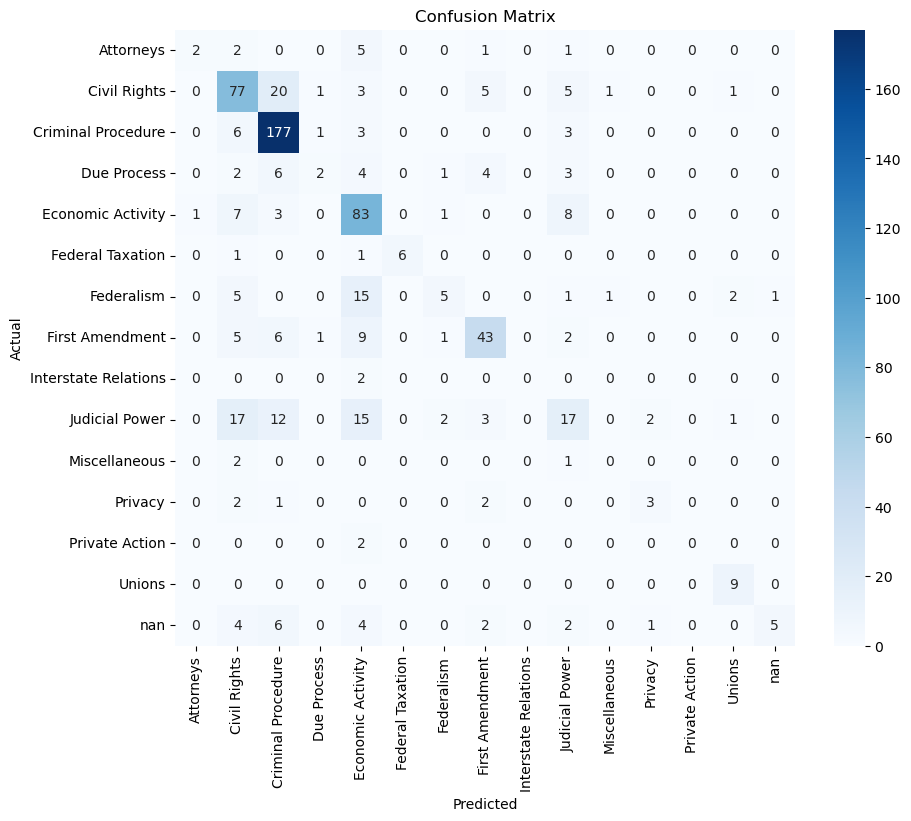

In [11]:
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Text(0, 0.5, 'Number of Documents')

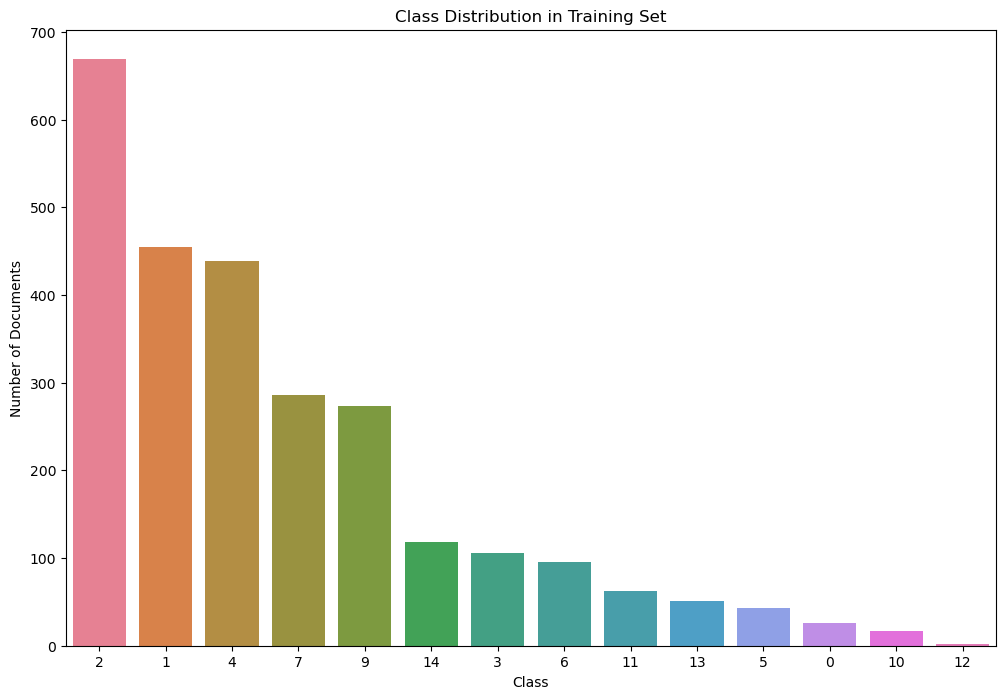

In [12]:
import matplotlib.pyplot as plt

import seaborn as sns
\
# Convert y_train to pandas DataFrame
y_train_df = pd.DataFrame(y_train, columns=['issue_area'])

# Class Distribution Plot with Different Colors and a Color Scale
plt.figure(figsize=(12, 8))
class_colors = sns.color_palette("husl", n_colors=len(y_train_df['issue_area'].unique()))  # Use a color palette
sns.countplot(data=y_train_df, x='issue_area', order=y_train_df['issue_area'].value_counts().index, palette=class_colors)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Documents')


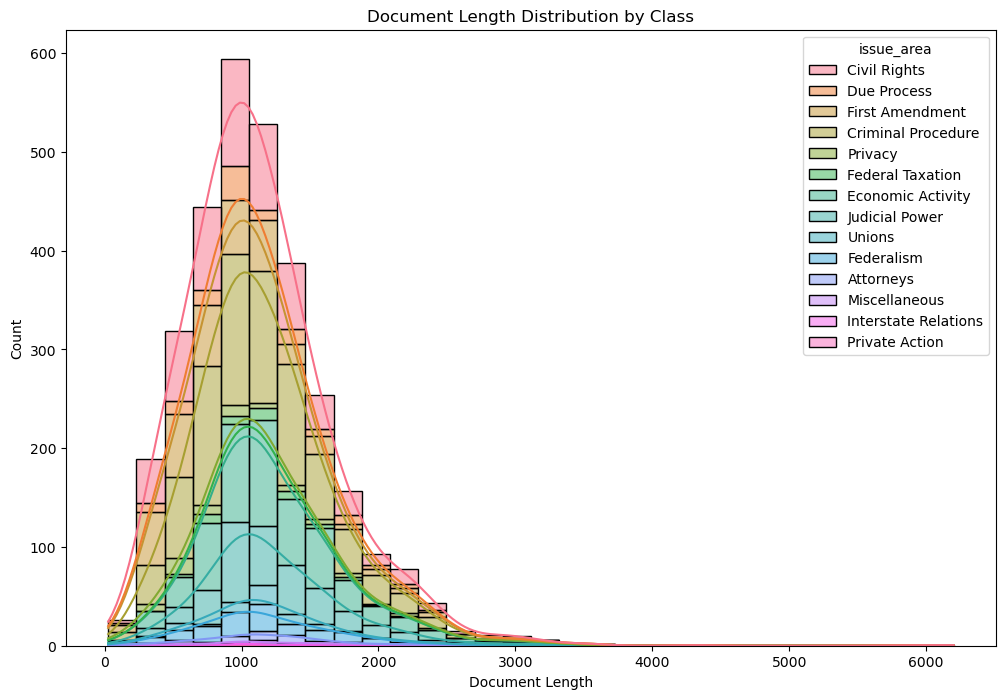

In [13]:
# Document Length Distribution by Class
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='facts_len', hue='issue_area', multiple='stack', bins=30, kde=True)
plt.title('Document Length Distribution by Class')
plt.xlabel('Document Length')
plt.ylabel('Count')
plt.show()


In [14]:
!pip install wordcloud


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\citris\\anaconda4\\lib\\site-packages\\numpy-1.21.6.dist-info\\METADATA'



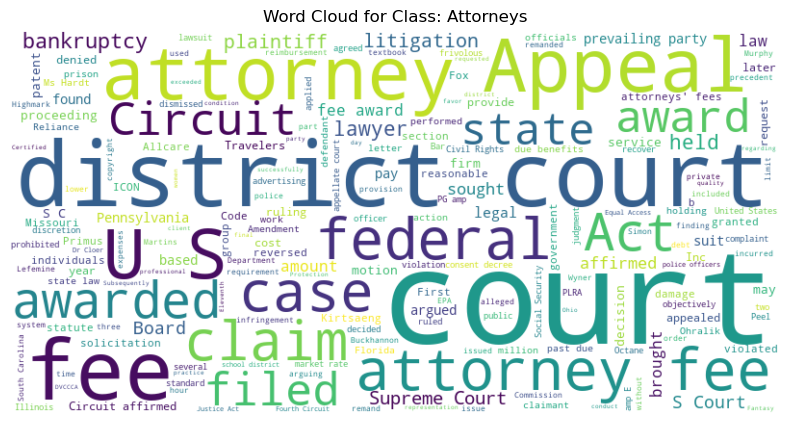

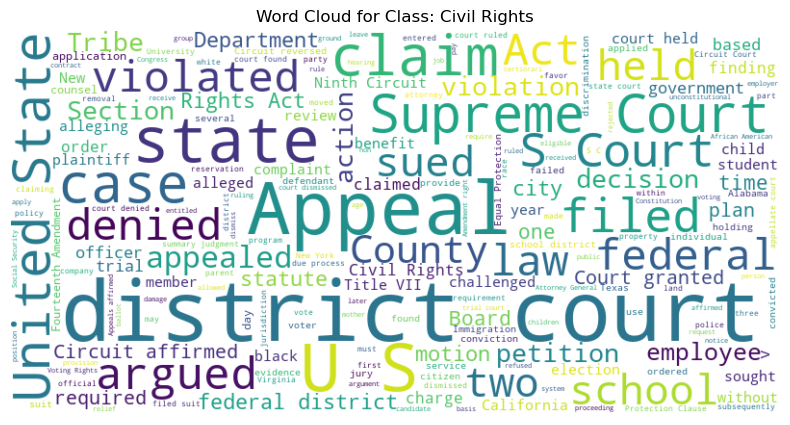

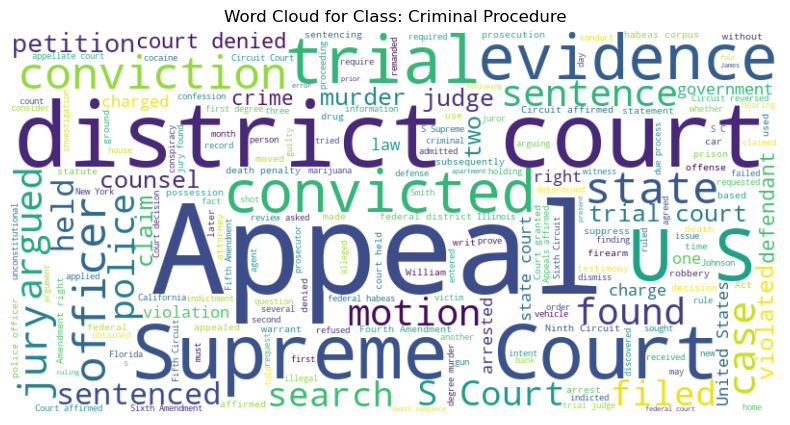

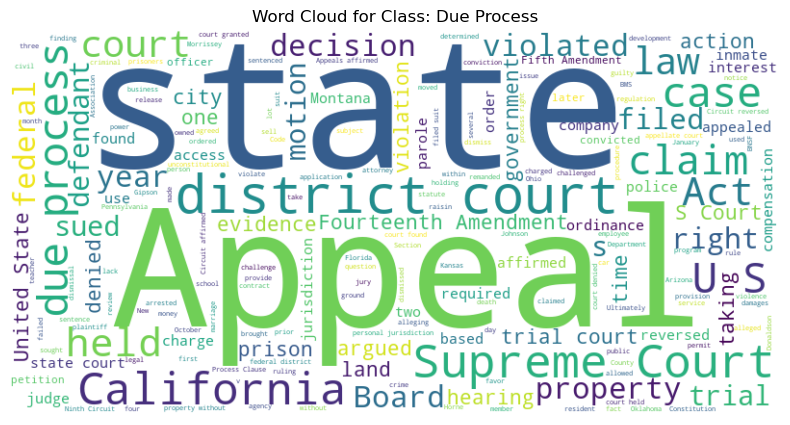

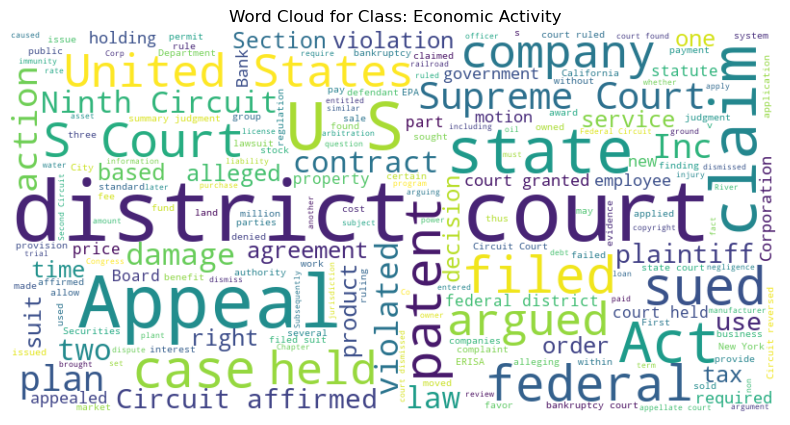

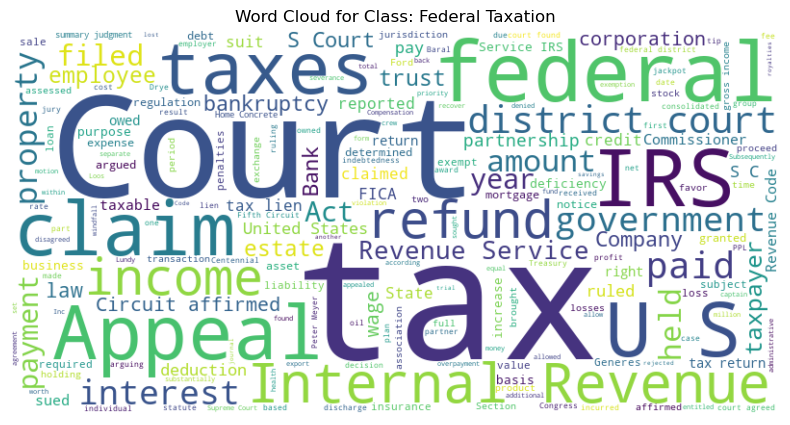

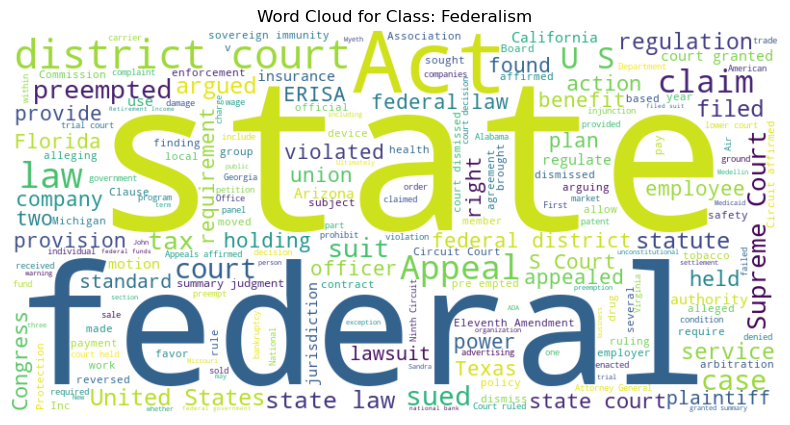

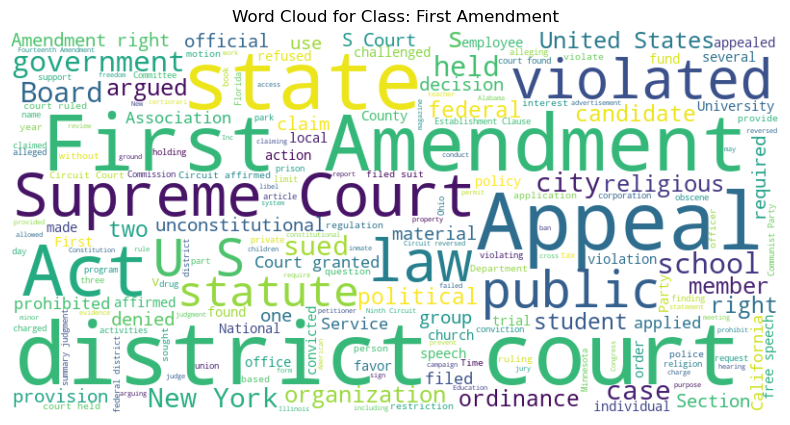

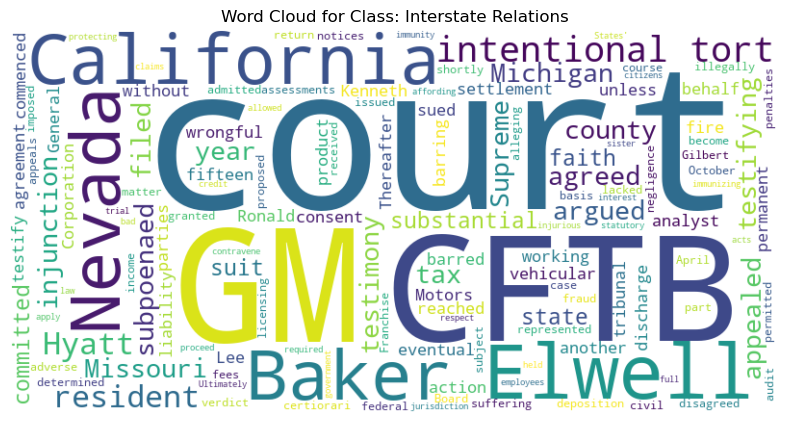

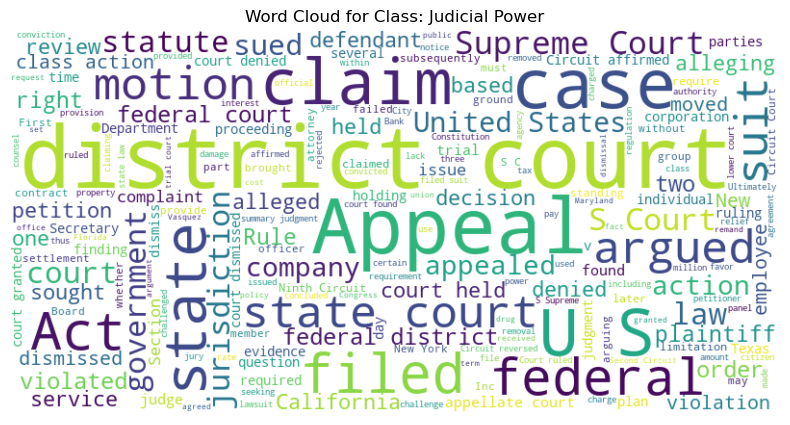

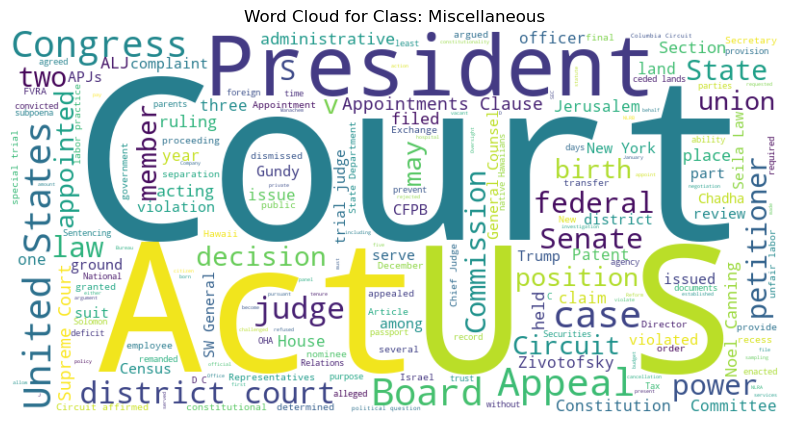

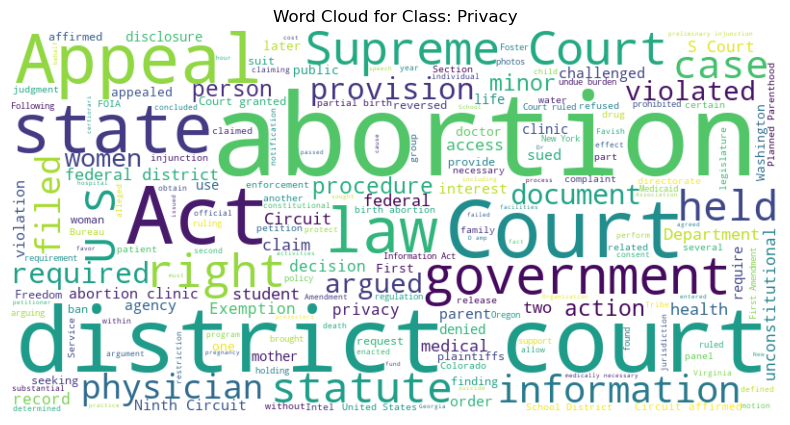

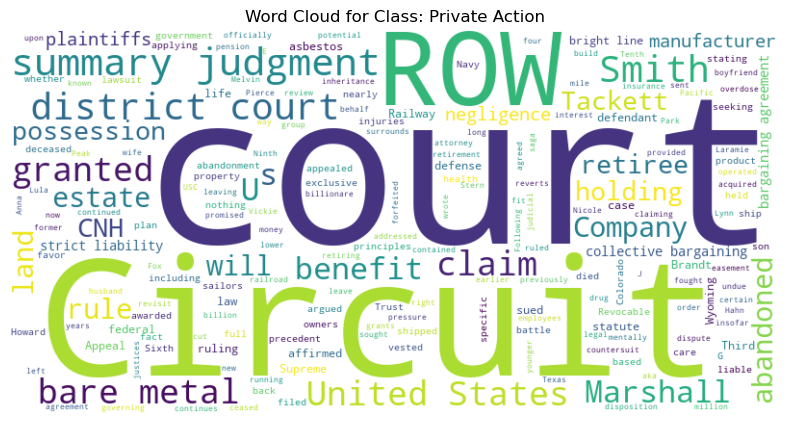

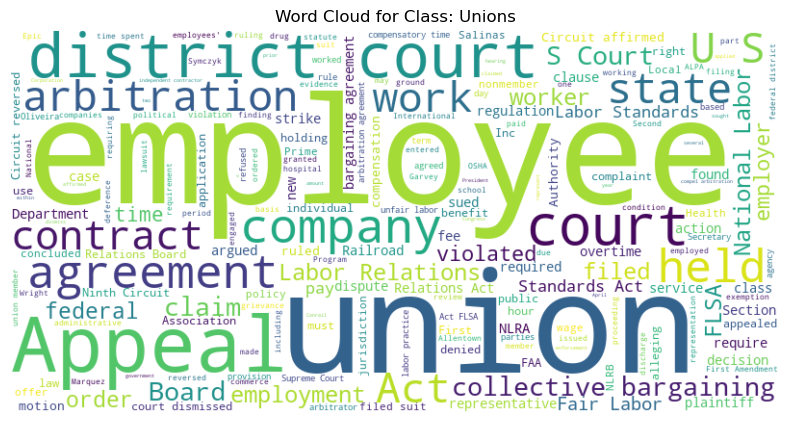

No data available for class: Word Cloud for Class: nan


In [15]:
from wordcloud import WordCloud

# Function to generate word cloud for a specific class
def generate_wordcloud(text, title):
    if text:  # Check if there is any text for the given class
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.show()
    else:
        print(f"No data available for class: {title}")

# Generate word clouds for each class
for class_label in label_encoder.classes_:
    class_text = ' '.join(data[data['issue_area'] == class_label]['processed_facts'])
    generate_wordcloud(class_text, f'Word Cloud for Class: {class_label}')


In [16]:
# Convert label_encoder.classes_ to strings
target_names = [str(class_label) for class_label in label_encoder.classes_]

# Evaluation on the test set
y_pred = best_model.predict(X_test)

# Decode the encoded labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Ensure consistent data types
y_test_decoded = y_test_decoded.astype(str)
y_pred_decoded = y_pred_decoded.astype(str)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded, target_names=target_names, zero_division='warn'))


Classification Report:
                      precision    recall  f1-score   support

           Attorneys       0.67      0.18      0.29        11
        Civil Rights       0.59      0.68      0.63       113
  Criminal Procedure       0.77      0.93      0.84       190
         Due Process       0.40      0.09      0.15        22
   Economic Activity       0.57      0.81      0.67       103
    Federal Taxation       1.00      0.75      0.86         8
          Federalism       0.50      0.17      0.25        30
     First Amendment       0.72      0.64      0.68        67
Interstate Relations       0.00      0.00      0.00         2
      Judicial Power       0.40      0.25      0.30        69
       Miscellaneous       0.00      0.00      0.00         3
             Privacy       0.50      0.38      0.43         8
      Private Action       0.00      0.00      0.00         2
              Unions       0.69      1.00      0.82         9
                 nan       0.83      0.21     